

abstract
Intro
method
result




Initial parameters:


1.   11,173,962
2.   



# Deep Learning Mini-Project

Team members:

1. Nishith Sharma
2. Utkarsh Atri
3. Parth Bharadwaj

# Custom ResNet for CiFar dataset
Objective: In this mini-project you are tasked with coming up with a modified residual network (ResNet)
architecture with the highest test accuracy on the CIFAR-10 image classification dataset, under the
constraint that your model has no more than 5 million parameters.

# 1. Load Libraries

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torchvision
import torchvision.transforms as transforms
import os
import argparse

# 2. Build the Basic Block for ResNet:
A basic ResNet block is composed by two layers of 3x3 conv/batchnorm/relu. In the picture, the lines represent the residual operation. The dotted line means that the shortcut was applied to match the input and the output dimension.
>>
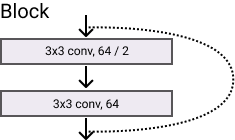



In [ ]:
class BasicBlock(nn.Module):

  def __init__(self, in_planes, planes, kernel_size, skip_kernel, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=kernel_size, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=kernel_size, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=skip_kernel, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

  def forward(self, x):
      out = F.relu(self.bn1(self.conv1(x)))
      out = self.bn2(self.conv2(out))
      out += self.shortcut(x)
      out = F.relu(out)
      return out

# 3. ResNet Class with customizable components:
* No. of Residual Layers
* No. of Residual Blocks in Residual Layer i
* No. of channels in Residual Layer i
* Conv. kernel size in Residual Layer i
* Skip connection kernel size in Residual Layer i
* Average pool kernel size
* layers container
* strides for layers

In [ ]:
class ResNet(nn.Module):

    def __init__(self,N:int, B:list, C:list, F:list, K:list, P:int, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = C[0]
        self.block = BasicBlock
        self.N = N                # No. of Residual Layers
        self.B = B                # No. of Residual Blocks in Residual Layer i
        self.C = C                # No. of channels in Residual Layer i
        self.F = F                # Conv. kernel size in Residual Layer i
        self.K = K                # Skip connection kernel size in Residual Layer i
        self.P = P                # Average pool kernel size
        self.layers = []          # layers container
        self.S = [2] * N          # strides for layers
        self.S[0] = 1

        # Output Liner layer input dimension
        self.outLayerInSize = C[N-1]*(32//(P*2**(N-1)))*(32//(P*2**(N-1)))

        # Print Model Config
        print("\n\nModel Config: "
            "\n-------------------------------------"
            "\nN (# Layers)\t:",self.N,
            "\nB (# Blocks)\t:",self.B,
            "\nC (# Channels)\t:",C,
            "\nF (Conv Kernel)\t:",F,
            "\nK (Skip Kernel)\t:",K,
            "\nP (Pool Kernel)\t:",P,)

        self.conv1 = nn.Conv2d(3, C[0], kernel_size=F[0], stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(C[0])
        for i in range(N): 
            exec("self.layer{} = self._make_layer(self.block, self.C[{}], self.B[{}], self.F[{}], self.K[{}], self.S[{}])"\
                .format(i+1,i,i,i,i,i))
            exec("self.layers.append(self.layer{})".format(i+1))
        self.linear = nn.Linear(self.outLayerInSize, num_classes)
        

    def _make_layer(self, block, planes, num_blocks, kernel_size, skip_kernel, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, kernel_size, skip_kernel, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        for layer in self.layers:
            out = layer(out)
        out = F.avg_pool2d(out, self.P)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

# 4. Custom ResNet Model Configurations
Here we will test around with various forms of parameters to assess which one gives the best accuracy for total parameters to be under 5 million.

In [ ]:
def custom_model():

    B=[3,3,2,3]           # Bi : # Residual blocks in Residual Layer i
    C=[64,128,128,256]    # Ci : # channels in Residual Layer i
    F=[3,3,3,3]           # Fi : Conv. kernel size in Residual Layer i
    K=[1,1,1,1]           # Ki : Skip connection kernel size in Residual Layer i
    P=4                   # P  : Average pool kernel size
    N=len(B)              # N: : # Residual Layers

    return ResNet(N, B, C, F, K, P)     # Return the custom model class

def ResNet10_1():

    N=4
    B=[1,1,1,1]
    C=[64,128,256,512]
    F=[3,3,3,3]
    K=[1,1,1,1]
    P=4

    return ResNet(N, B, C, F, K, P)

def ResNet10_2():

    N=3
    B=[1,1,1]
    C=[32,64,128]
    F=[3,3,3]
    K=[1,1,1]
    P=4

    return ResNet(N, B, C, F, K, P)

def ResNet24_2():

    N=3
    B=[3,3,3]
    C=[64,128,256]
    F=[3,3,3]
    K=[1,1,1]
    P=4

    return ResNet(N, B, C, F, K, P)


def ResNet34_1():

    N=4
    B=[3,4,6,3]
    C=[64,128,256,512]
    F=[3,3,3,3]
    K=[1,1,1,1]
    P=4

    return ResNet(N, B, C, F, K, P)


def ResNet16_1():

    B=[2,1,2,2]
    C=[64,128,256,256]
    F=[3,3,3,3]
    K=[1,1,1,1]
    P=4
    N=len(B)

    return ResNet(N, B, C, F, K, P)


def ResNet24_1():

    B=[3,3,2,3]
    C=[64,128,128,256]
    F=[3,3,3,3]
    K=[1,1,1,1]
    P=4
    N=len(B)

    return ResNet(N, B, C, F, K, P)


def ResNet48_1():

    B=[8,5,5,5]
    C=[64,128,128,128]
    F=[3,3,3,3]
    K=[1,1,1,1]
    P=4
    N=len(B)

    return ResNet(N, B, C, F, K, P)


def ResNet_test():

    B=[1,1,1,1]
    C=[64,128,256,512]
    F=[3,3,3,3]
    K=[1,1,1,1]
    P=4
    N=len(B)

    return ResNet(N, B, C, F, K, P)


def ResNetXYZ():

    B=[1,1,1]
    C=[64,128,128]
    F= [3,3,3]
    K= [1,1,1]
    P=4
    N=len(B)

    return ResNet(N, B, C, F, K, P)


def ResNet86():

    B= [10,8,10,14]
    C= [16,32,64,128]
    F= [3,3,3,3]
    K= [1,1,1,1]
    P= 4
    N= len(B)

    return ResNet(N, B, C, F, K, P)


def ResNet12():

    B= [2,1,1,1]
    C= [64,128,256,512]
    F= [3,3,3,3]
    K= [1,1,1,1]
    P= 4
    N= len(B)

    return ResNet(N, B, C, F, K, P)


def ResNet32():

    B= [4,4,4,3]
    C= [32,64,128,256]
    F= [3,3,3,3]
    K= [1,1,1,1]
    P= 4
    N= len(B)

    return ResNet(N, B, C, F, K, P)


def ResNet8():

    B= [1,1,1]
    C= [128,256,512]
    F= [3,3,3]
    K= [1,1,1]
    P= 4
    N= len(B)

    return ResNet(N, B, C, F, K, P)

In [ ]:
def Proposed_model():

    B=[4,4,4,4]           # Bi : # Residual blocks in Residual Layer i
    C=[64,128,256,512]    # Ci : # channels in Residual Layer i
    F=[3,3,3,3]           # Fi : Conv. kernel size in Residual Layer i
    K=[2,2,2,2]           # Ki : Skip connection kernel size in Residual Layer i
    P=3                   # P  : Average pool kernel size
    N=len(B)              # N: : # Residual Layers

    return ResNet(N, B, C, F, K, P)     # Return the custom model class

# 5. Load and prepare data

In [ ]:
# Data
print('==> Preparing data..')
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

==> Preparing data..


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


# 6. Define Train and Test functions

In [ ]:
# Training
def train(epoch):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        print('Loss: %.3f | Acc: %.3f%% (%d/%d)'
                     % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))

In [ ]:
#Testing
def test(epoch):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            print('Loss: %.3f | Acc: %.3f%% (%d/%d)'
                         % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))

    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving..')
        state = {
            'net': net.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/ckpt.pth')
        best_acc = acc

# 7. Building the model

In [ ]:
lr = 0.1           # Define the learning rate

device = 'cuda' if torch.cuda.is_available() else 'cpu'

best_acc = 0       # best test accuracy
start_epoch = 0    # start from epoch 0 or last checkpoint epoch

In [ ]:
# Model
print('==> Building model..')
net = custom_model()

net = net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.1,
                      momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

==> Building model..


Model Config: 
-------------------------------------
N (# Layers)	: 4 
B (# Blocks)	: [3, 3, 2, 3] 
C (# Channels)	: [64, 128, 128, 256] 
F (Conv Kernel)	: [3, 3, 3, 3] 
K (Skip Kernel)	: [1, 1, 1, 1] 
P (Pool Kernel)	: 4


In [ ]:
from torchsummary import summary
summary(ResNet8().cuda(),(3,32,32))



Model Config: 
-------------------------------------
N (# Layers)	: 3 
B (# Blocks)	: [1, 1, 1] 
C (# Channels)	: [128, 256, 512] 
F (Conv Kernel)	: [3, 3, 3] 
K (Skip Kernel)	: [1, 1, 1] 
P (Pool Kernel)	: 4
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 32, 32]           3,456
       BatchNorm2d-2          [-1, 128, 32, 32]             256
            Conv2d-3          [-1, 128, 32, 32]         147,456
       BatchNorm2d-4          [-1, 128, 32, 32]             256
            Conv2d-5          [-1, 128, 32, 32]         147,456
       BatchNorm2d-6          [-1, 128, 32, 32]             256
        BasicBlock-7          [-1, 128, 32, 32]               0
            Conv2d-8          [-1, 256, 16, 16]         294,912
       BatchNorm2d-9          [-1, 256, 16, 16]             512
           Conv2d-10          [-1, 256, 16, 16]         589,824
      BatchNorm2d-11

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(net):,} trainable parameters')

The model has 4,935,242 trainable parameters


In [ ]:
count_parameters(ResNet8())



Model Config: 
-------------------------------------
N (# Layers)	: 3 
B (# Blocks)	: [1, 1, 1] 
C (# Channels)	: [128, 256, 512] 
F (Conv Kernel)	: [3, 3, 3] 
K (Skip Kernel)	: [1, 1, 1] 
P (Pool Kernel)	: 4


4911754

# 8. Train the model

In [ ]:
for epoch in range(start_epoch, start_epoch+200):
    train(epoch)
    test(epoch)
    scheduler.step()

Streaming output truncated to the last 5000 lines.
Loss: 0.219 | Acc: 94.971% (3229/3400)
Loss: 0.218 | Acc: 94.943% (3323/3500)
Loss: 0.219 | Acc: 95.000% (3420/3600)
Loss: 0.224 | Acc: 94.892% (3511/3700)
Loss: 0.223 | Acc: 94.921% (3607/3800)
Loss: 0.218 | Acc: 95.000% (3705/3900)
Loss: 0.217 | Acc: 95.050% (3802/4000)
Loss: 0.217 | Acc: 95.024% (3896/4100)
Loss: 0.217 | Acc: 95.048% (3992/4200)
Loss: 0.216 | Acc: 95.070% (4088/4300)
Loss: 0.215 | Acc: 95.114% (4185/4400)
Loss: 0.215 | Acc: 95.089% (4279/4500)
Loss: 0.215 | Acc: 95.109% (4375/4600)
Loss: 0.214 | Acc: 95.106% (4470/4700)
Loss: 0.218 | Acc: 95.021% (4561/4800)
Loss: 0.214 | Acc: 95.082% (4659/4900)
Loss: 0.216 | Acc: 95.040% (4752/5000)
Loss: 0.213 | Acc: 95.118% (4851/5100)
Loss: 0.212 | Acc: 95.115% (4946/5200)
Loss: 0.211 | Acc: 95.132% (5042/5300)
Loss: 0.208 | Acc: 95.185% (5140/5400)
Loss: 0.209 | Acc: 95.200% (5236/5500)
Loss: 0.209 | Acc: 95.232% (5333/5600)
Loss: 0.208 | Acc: 95.211% (5427/5700)
Loss: 0.206 |

# 9. Results

In [ ]:
print("The best accuracy after training :", best_acc)
print(f'The model has {count_parameters(net):,} trainable parameters')

The best accuracy after training : 95.42
The model has 4,935,242 trainable parameters


# 10. Additional Experiments

Here we have added the code and the other experiments to eventually come to the above solutions. We used various configurations to find the model with params under 5 million and pick the one with maximum accuracy.

Note: In order to save time we have conducted 4 experiments in this notebook and the rest of the experiments were conducted in other notebook to utilize time efficiently. We have included the results of other expirements in the report.

In [ ]:
print('==> Experiment1 ..')
net = ResNet8()

net = net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.1,
                      momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(net):,} trainable parameters')

for epoch in range(start_epoch, start_epoch+25):
    train(epoch)
    test(epoch)
    scheduler.step()

Streaming output truncated to the last 5000 lines.
Loss: 0.605 | Acc: 81.200% (2842/3500)
Loss: 0.610 | Acc: 81.194% (2923/3600)
Loss: 0.612 | Acc: 81.189% (3004/3700)
Loss: 0.612 | Acc: 81.158% (3084/3800)
Loss: 0.610 | Acc: 81.282% (3170/3900)
Loss: 0.605 | Acc: 81.450% (3258/4000)
Loss: 0.603 | Acc: 81.488% (3341/4100)
Loss: 0.604 | Acc: 81.333% (3416/4200)
Loss: 0.602 | Acc: 81.302% (3496/4300)
Loss: 0.599 | Acc: 81.500% (3586/4400)
Loss: 0.597 | Acc: 81.556% (3670/4500)
Loss: 0.598 | Acc: 81.522% (3750/4600)
Loss: 0.598 | Acc: 81.532% (3832/4700)
Loss: 0.597 | Acc: 81.625% (3918/4800)
Loss: 0.593 | Acc: 81.714% (4004/4900)
Loss: 0.595 | Acc: 81.600% (4080/5000)
Loss: 0.592 | Acc: 81.647% (4164/5100)
Loss: 0.590 | Acc: 81.692% (4248/5200)
Loss: 0.587 | Acc: 81.792% (4335/5300)
Loss: 0.586 | Acc: 81.833% (4419/5400)
Loss: 0.585 | Acc: 81.764% (4497/5500)
Loss: 0.586 | Acc: 81.821% (4582/5600)
Loss: 0.587 | Acc: 81.772% (4661/5700)
Loss: 0.584 | Acc: 81.828% (4746/5800)
Loss: 0.587 |

In [ ]:

print('==> Experiment1 ..')
net = ResNet12()

net = net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.1,
                      momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(net):,} trainable parameters')

for epoch in range(start_epoch, start_epoch+25):
    train(epoch)
    test(epoch)
    scheduler.step()

Streaming output truncated to the last 5000 lines.
Loss: 0.639 | Acc: 79.676% (2709/3400)
Loss: 0.641 | Acc: 79.571% (2785/3500)
Loss: 0.639 | Acc: 79.611% (2866/3600)
Loss: 0.641 | Acc: 79.622% (2946/3700)
Loss: 0.643 | Acc: 79.526% (3022/3800)
Loss: 0.641 | Acc: 79.538% (3102/3900)
Loss: 0.637 | Acc: 79.700% (3188/4000)
Loss: 0.637 | Acc: 79.585% (3263/4100)
Loss: 0.638 | Acc: 79.548% (3341/4200)
Loss: 0.634 | Acc: 79.605% (3423/4300)
Loss: 0.632 | Acc: 79.659% (3505/4400)
Loss: 0.630 | Acc: 79.667% (3585/4500)
Loss: 0.632 | Acc: 79.652% (3664/4600)
Loss: 0.629 | Acc: 79.745% (3748/4700)
Loss: 0.628 | Acc: 79.750% (3828/4800)
Loss: 0.626 | Acc: 79.837% (3912/4900)
Loss: 0.632 | Acc: 79.760% (3988/5000)
Loss: 0.628 | Acc: 79.863% (4073/5100)
Loss: 0.629 | Acc: 79.808% (4150/5200)
Loss: 0.632 | Acc: 79.642% (4221/5300)
Loss: 0.628 | Acc: 79.759% (4307/5400)
Loss: 0.630 | Acc: 79.709% (4384/5500)
Loss: 0.631 | Acc: 79.732% (4465/5600)
Loss: 0.632 | Acc: 79.632% (4539/5700)
Loss: 0.631 |

In [ ]:
print('==> Experiment2 ..')
net = ResNet16_1()

net = net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.1,
                      momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(net):,} trainable parameters')

for epoch in range(start_epoch, start_epoch+25):
    train(epoch)
    test(epoch)
    scheduler.step()

Streaming output truncated to the last 5000 lines.
Loss: 0.615 | Acc: 80.097% (2483/3100)
Loss: 0.611 | Acc: 80.281% (2569/3200)
Loss: 0.606 | Acc: 80.273% (2649/3300)
Loss: 0.606 | Acc: 80.265% (2729/3400)
Loss: 0.610 | Acc: 80.229% (2808/3500)
Loss: 0.609 | Acc: 80.361% (2893/3600)
Loss: 0.609 | Acc: 80.324% (2972/3700)
Loss: 0.612 | Acc: 80.237% (3049/3800)
Loss: 0.610 | Acc: 80.179% (3127/3900)
Loss: 0.610 | Acc: 80.150% (3206/4000)
Loss: 0.610 | Acc: 80.098% (3284/4100)
Loss: 0.609 | Acc: 80.214% (3369/4200)
Loss: 0.603 | Acc: 80.372% (3456/4300)
Loss: 0.601 | Acc: 80.477% (3541/4400)
Loss: 0.597 | Acc: 80.622% (3628/4500)
Loss: 0.599 | Acc: 80.565% (3706/4600)
Loss: 0.602 | Acc: 80.511% (3784/4700)
Loss: 0.603 | Acc: 80.458% (3862/4800)
Loss: 0.599 | Acc: 80.531% (3946/4900)
Loss: 0.602 | Acc: 80.560% (4028/5000)
Loss: 0.602 | Acc: 80.569% (4109/5100)
Loss: 0.603 | Acc: 80.462% (4184/5200)
Loss: 0.600 | Acc: 80.528% (4268/5300)
Loss: 0.599 | Acc: 80.611% (4353/5400)
Loss: 0.600 |

In [ ]:
print('==> Experiment3 ..')
net = ResNet_test()

net = net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.1,
                      momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(net):,} trainable parameters')

for epoch in range(start_epoch, start_epoch+25):
    train(epoch)
    test(epoch)
    scheduler.step()

==> Experiment3 ..


Model Config: 
-------------------------------------
N (# Layers)	: 4 
B (# Blocks)	: [1, 1, 1, 1] 
C (# Channels)	: [64, 128, 256, 512] 
F (Conv Kernel)	: [3, 3, 3, 3] 
K (Skip Kernel)	: [1, 1, 1, 1] 
P (Pool Kernel)	: 4
The model has 4,903,242 trainable parameters

Epoch: 0
Loss: 2.351 | Acc: 7.812% (10/128)
Loss: 2.381 | Acc: 10.156% (26/256)
Loss: 2.407 | Acc: 13.281% (51/384)
Loss: 2.482 | Acc: 13.477% (69/512)
Loss: 2.530 | Acc: 14.219% (91/640)
Loss: 2.521 | Acc: 15.104% (116/768)
Loss: 2.559 | Acc: 14.732% (132/896)
Loss: 2.632 | Acc: 15.430% (158/1024)
Loss: 2.649 | Acc: 15.799% (182/1152)
Loss: 2.622 | Acc: 16.016% (205/1280)
Loss: 2.582 | Acc: 16.477% (232/1408)
Loss: 2.552 | Acc: 16.927% (260/1536)
Loss: 2.537 | Acc: 17.368% (289/1664)
Loss: 2.517 | Acc: 17.355% (311/1792)
Loss: 2.506 | Acc: 17.812% (342/1920)
Loss: 2.492 | Acc: 17.725% (363/2048)
Loss: 2.472 | Acc: 18.153% (395/2176)
Loss: 2.460 | Acc: 18.446% (425/2304)
Loss: 2.434 | Acc: 19.161% (466

In [ ]:
# Failed Experiment

# class BasicBlock(nn.Module):
#     expansion = 1

#     def __init__(self, in_planes, planes, stride=1):
#         super(BasicBlock, self).__init__()
#         self.conv1 = nn.Conv2d(
#             in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
#         self.bn1 = nn.BatchNorm2d(planes)
#         self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
#                                stride=1, padding=1, bias=False)
#         self.bn2 = nn.BatchNorm2d(planes)

#         self.shortcut = nn.Sequential()
#         if stride != 1 or in_planes != self.expansion*planes:
#             self.shortcut = nn.Sequential(
#                 nn.Conv2d(in_planes, self.expansion*planes,
#                           kernel_size=1, stride=stride, bias=False),
#                 nn.BatchNorm2d(self.expansion*planes)
#             )

#     def forward(self, x):
#         out = F.relu(self.bn1(self.conv1(x)))
#         out = self.bn2(self.conv2(out))
#         out += self.shortcut(x)
#         out = F.relu(out)
#         return out

# class Bottleneck(nn.Module):
#     expansion = 4

#     def __init__(self, in_planes, planes, stride=1):
#         super(Bottleneck, self).__init__()
#         self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
#         self.bn1 = nn.BatchNorm2d(planes)
#         self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
#                                stride=stride, padding=1, bias=False)
#         self.bn2 = nn.BatchNorm2d(planes)
#         self.conv3 = nn.Conv2d(planes, self.expansion *
#                                planes, kernel_size=1, bias=False)
#         self.bn3 = nn.BatchNorm2d(self.expansion*planes)

#         self.shortcut = nn.Sequential()
#         if stride != 1 or in_planes != self.expansion*planes:
#             self.shortcut = nn.Sequential(
#                 nn.Conv2d(in_planes, self.expansion*planes,
#                           kernel_size=1, stride=stride, bias=False),
#                 nn.BatchNorm2d(self.expansion*planes)
#             )

#     def forward(self, x):
#         out = F.relu(self.bn1(self.conv1(x)))
#         out = F.relu(self.bn2(self.conv2(out)))
#         out = self.bn3(self.conv3(out))
#         out += self.shortcut(x)
#         out = F.relu(out)
#         return out

# class ResNet(nn.Module):
#     def __init__(self, block, num_blocks, num_classes=10):
#         super(ResNet, self).__init__()
#         self.in_planes = 64

#         self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
#                                stride=1, padding=1, bias=False)
#         self.bn1 = nn.BatchNorm2d(64)
#         self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
#         self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
#         self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
#         self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
#         self.linear = nn.Linear(512*block.expansion, num_classes)

#     def _make_layer(self, block, planes, num_blocks, stride):
#         strides = [stride] + [1]*(num_blocks-1)
#         layers = []
#         for stride in strides:
#             layers.append(block(self.in_planes, planes, stride))
#             self.in_planes = planes * block.expansion
#         return nn.Sequential(*layers)

#     def forward(self, x):
#         out = F.relu(self.bn1(self.conv1(x)))
#         out = self.layer1(out)
#         out = self.layer2(out)
#         out = self.layer3(out)
#         out = self.layer4(out)
#         out = F.avg_pool2d(out, 4)
#         out = out.view(out.size(0), -1)
#         out = self.linear(out)
#         return out


# def ResNet18():
#     return ResNet(BasicBlock, [1, 1, 1, 1])


# def ResNet34():
#     return ResNet(BasicBlock, [3, 4, 6, 3])


# def ResNet50():
#     return ResNet(Bottleneck, [3, 4, 6, 3])


# def ResNet101():
#     return ResNet(Bottleneck, [3, 4, 23, 3])


# def ResNet152():
#     return ResNet(Bottleneck, [3, 8, 36, 3])


# def test():
#     net = ResNet18()
#     y = net(torch.randn(1, 3, 32, 32))
#     print(y.size())